# Анализ поведения пользователей мобильного приложения

**Описание проекта**

Необходимо исследовать результаты A/A/B-эксперимента мобильного приложения. Дизайнеры захотели поменять шрифты во всем приложении. Создали 2 контрольные группы со старыми шрифтами и 1 экспериментальную группу с новым шрифтом. 

По результатам эксперимента необходимо выяснить какой шрифт лучше.

**Описание данных**

Каждая запись в логе — это действие пользователя, или событие.

Файл /datasets/logs_exp.csv:
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

**План работы**

- Шаг 1.Подготовка данных: проверка на дубликаты и пропуски, изменение типа данных;

- Шаг 2. Изучение и проверка данных: изучение происходящих событий в приложении ;

- Шаг 3. Изучение результатов эксперимента: проведение А/А/В теста, принятие решений на основании А/А/В теста.

## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import scipy.stats as stats
import numpy as np
import math as mth

In [2]:
try:
    data = pd.read_csv('/datasets/logs_exp.csv', sep = '\t')
except:
    data = pd.read_csv('C:/Users/admin/Desktop/Проект 2/logs_exp.csv', sep = '\t')

In [3]:
data.head(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
#общая информация о ДФ
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [5]:
# замена названий столбцов
data.columns = ['event_name', 'user_id', 'timestamp', 'group_id']

In [6]:
# замена типа данных
data['date_time'] = pd.to_datetime(data['timestamp'], unit='s')
data['date'] = data['date_time'].astype('datetime64[D]')

In [7]:
# поиск явных дубликатов
print('Явных дубликатов:', data.duplicated().sum())
print('Доля явных дубликатов: {:.3}'.format(data.duplicated().sum()/len(data)))
# удаление явных дубликатов
data = data.drop_duplicates()
print('Явных дубликатов после удаления:', data.duplicated().sum())

Явных дубликатов: 413
Доля явных дубликатов: 0.00169
Явных дубликатов после удаления: 0


In [8]:
# поиск пропусков
data.isna().sum()

event_name    0
user_id       0
timestamp     0
group_id      0
date_time     0
date          0
dtype: int64

In [9]:
# проверка на пересечение пользователей между группами  
gr246 = data.query('group_id == 246')['user_id'].drop_duplicates()
gr247 = data.query('group_id == 247')['user_id'].drop_duplicates()
gr248 = data.query('group_id == 248')['user_id'].drop_duplicates()

print('Количество пользователей, попавших в 246 и 247 группы:', len(gr246) - len(gr246[np.logical_not(gr246.isin(gr247))]))
print('Количество пользователей, попавших в 246 и 248 группы:', len(gr246) - len(gr246[np.logical_not(gr246.isin(gr248))]))
print('Количество пользователей, попавших в 247 и 248 группы:', len(gr247) - len(gr247[np.logical_not(gr247.isin(gr248))]))

Количество пользователей, попавших в 246 и 247 группы: 0
Количество пользователей, попавших в 246 и 248 группы: 0
Количество пользователей, попавших в 247 и 248 группы: 0


**Выводы:**
- заменил название столбцов;
- добавил два новых столбца с датой и временем;
- удалил явные дубликаты;
- проверил группы на пересечение пользователей, их не оказалось.

## Изучение и проверка данных

In [10]:
data.head(5)

,event_name,user_id,timestamp,group_id,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [11]:
print('Количество событий в логе:', len(data['event_name'].unique()))
print('Общее количество событий в логе:', len(data['event_name']))

Количество событий в логе: 5
Общее количество событий в логе: 243713


In [12]:
print('Количество пользователей в логе:', data['user_id'].nunique())

Количество пользователей в логе: 7551


In [13]:
data.head(10)

,event_name,user_id,timestamp,group_id,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25
5,CartScreenAppear,6217807653094995999,1564055323,248,2019-07-25 11:48:43,2019-07-25
6,OffersScreenAppear,8351860793733343758,1564066242,246,2019-07-25 14:50:42,2019-07-25
7,MainScreenAppear,5682100281902512875,1564085677,246,2019-07-25 20:14:37,2019-07-25
8,MainScreenAppear,1850981295691852772,1564086702,247,2019-07-25 20:31:42,2019-07-25
9,MainScreenAppear,5407636962369102641,1564112112,246,2019-07-26 03:35:12,2019-07-26


In [14]:
print('В среднем на одного пользователя приходится {:0.5} событий.'.format(data.groupby('user_id')
                                                                       .agg({'event_name': 'count'})['event_name'].mean()))

В среднем на одного пользователя приходится 32.276 событий.


In [15]:
# максимальная и минимальная дата
max_date = max(data['date_time'])
min_date = min(data['date_time'])
print('Максимальная дата: {}. Минимальная дата: {}'.format(max_date, min_date))

Максимальная дата: 2019-08-07 21:15:17. Минимальная дата: 2019-07-25 04:43:36


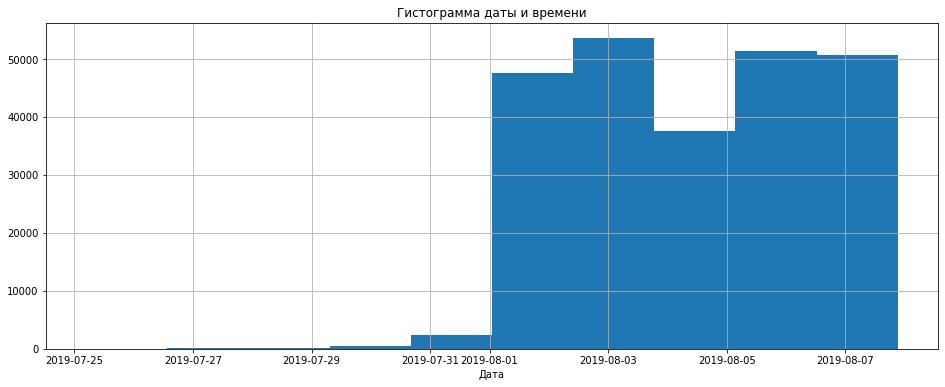

In [16]:
# гистограмма даты и времени
plt.figure(figsize=(16, 6))
data['date_time'].hist()
plt.title('Гистограмма даты и времени')
plt.xlabel('Дата')
plt.show()

- по моим наблюдениям более полные данные начинаются с 1 августа 2019 года.

In [17]:
# отбросим более старые данные
data2 = data.copy()
data2 = data2.query('date >= "2019-08-01"').reset_index(drop=True)
max_date2 = max(data2['date_time'])
min_date2 = min(data2['date_time'])
print('Максимальная дата без старых данных: {}. Минимальная дата без старых данных: {}'.format(max_date2, min_date2))

Максимальная дата без старых данных: 2019-08-07 21:15:17. Минимальная дата без старых данных: 2019-08-01 00:07:28


In [18]:
print('Количество событий в логе без старых данных:', len(data2['event_name'].unique()))
print('Общее количество событий в логе без старых данных:', len(data2['event_name']))
print('Доля отсеянных событий: {:0.4}'.format((len(data['event_name']) - len(data2['event_name']))/len(data['event_name'])))

Количество событий в логе без старых данных: 5
Общее количество событий в логе без старых данных: 240887
Доля отсеянных событий: 0.0116


In [19]:
print('Количество пользователей в логе без старых данных:', data2['user_id'].nunique())
print('Доля отсеянных пользователей: {:0.3}'.format((data['user_id'].nunique() - data2['user_id'].nunique())
                                                /data['user_id'].nunique()))

Количество пользователей в логе без старых данных: 7534
Доля отсеянных пользователей: 0.00225


In [20]:
# количество пользователей в разных группах 
data2.pivot_table(index='group_id', values='user_id', aggfunc='nunique')

,user_id
group_id,
246,2484
247,2513
248,2537


**Выводы:**
- посчитал количество событий и количество пользователей в логе;
- определил среднее количество событий на одного пользователя;
- построил гистограмму дат и времени. По ней нашел даты соответствующие старым неполным данным. Отбросил их. Доля исключенных пользователей оказалась малой - 0.2251%. Думаю, что это мало повлияет на результат;
- количество событий после отброса старых данных не изменилось;
- проверил, что в итоговой таблице есть пользователи из всех трех групп.

## Изучение результатов эксперимента

In [21]:
# количество пользователей в каждой экспериментальной группе
data2.groupby('group_id').agg(users_in_group=('user_id', 'nunique')).reset_index()

,group_id,users_in_group
0,246,2484
1,247,2513
2,248,2537


**A/A тест между 246 и 247 группой** 

In [22]:
# делаю ДФ по группам
group246 = data2.query('group_id == 246')
group247 = data2.query('group_id == 247')
group248 = data2.query('group_id == 248')

In [23]:
# определяю самое популярное действие среди пользователей
group246_unique = (group246.groupby('event_name').agg(users_unique = ('user_id', 'nunique'))
                   .sort_values(by='users_unique', ascending=False).reset_index()
                   .assign(users_share = lambda x: x['users_unique']/group246['user_id'].nunique(),
                           total_unique_users = lambda x: group246['user_id'].nunique()))

group246_unique

,event_name,users_unique,users_share,total_unique_users
0,MainScreenAppear,2450,0.986312,2484
1,OffersScreenAppear,1542,0.620773,2484
2,CartScreenAppear,1266,0.509662,2484
3,PaymentScreenSuccessful,1200,0.483092,2484
4,Tutorial,278,0.111916,2484


In [24]:
group247_unique = (group247.groupby('event_name').agg(users_unique = ('user_id', 'nunique'))
                   .sort_values(by='users_unique', ascending=False).reset_index()
                   .assign(users_share = lambda x: x['users_unique']/group247['user_id'].nunique(),
                           total_unique_users = lambda x: group247['user_id'].nunique()))
group247_unique

,event_name,users_unique,users_share,total_unique_users
0,MainScreenAppear,2476,0.985277,2513
1,OffersScreenAppear,1520,0.604855,2513
2,CartScreenAppear,1238,0.492638,2513
3,PaymentScreenSuccessful,1158,0.460804,2513
4,Tutorial,283,0.112614,2513


- самое популярное действие в обоих группах - это появление главного экрана. Буду проводить расчет статистической значимости по этим показателям.

**Расчет статистической значимости между группами.**

**A/A тест между 246 и 247 группой** 

**Нулевая гипотеза: статистическое различие долей пользователей при разных событиях между группами 246 и 247 - нет. Альтернативная гипотеза: есть статистическое различие долей пользователей при разных событиях между группами 246 и 247.**

In [25]:
# проверка по z-тесту
# создание функции для расчета статистической различия событий между группами 
def function_test(df1, df2, n, hypotesis):
    p_combined = (df1['users_unique'][n] + df2['users_unique'][n]) / (df1['total_unique_users'][n] + df2['total_unique_users'][n])
    difference = (df1['users_share'][n] - df2['users_share'][n])
    
    z_value = difference / mth.sqrt(p_combined*(1-p_combined)*((1/df1['total_unique_users'][n]) + (1/df2['total_unique_users'][n])))
     
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = stats.norm(0, 1)  
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    alpha = 0.1
    print('p-значение: {:0.4}'.format(p_value))

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу, которая гласит:', hypotesis[n])
    else:
        print('Не получилось отвергнуть нулевую гипотезу, которая гласит:', hypotesis[n])
        
    print('Различие между группами: {:0.5f}'.format(df2['users_share'][n]/df1['users_share'][n] - 1))

In [26]:
# список из гипотез для передачи функции
hypotesis246_247 = ['"Cтатистического различия при появлении главного экрана между группами 246 и 247 - нет"',
                    '"Статистического различия при появлении экрана предложений между группами 246 и 247 - нет"',
                    '"Статистического различия при появлении экрана корзины между группами 246 и 247 - нет"',
                    '"Статистического различия при появлении экрана успешного платежа между группами 246 и 247 - нет"',
                    '"Статистического различия при появлении экрана рекомендаций между группами 246 и 247 - нет"']

In [27]:
# объявляю цикл для прогонки функции
for i in range(5):
    function_test(group246_unique, group247_unique, i, hypotesis246_247)
    print()

p-значение: 0.7571
Не получилось отвергнуть нулевую гипотезу, которая гласит: "Cтатистического различия при появлении главного экрана между группами 246 и 247 - нет"
Различие между группами: -0.00105

p-значение: 0.2481
Не получилось отвергнуть нулевую гипотезу, которая гласит: "Статистического различия при появлении экрана предложений между группами 246 и 247 - нет"
Различие между группами: -0.02564

p-значение: 0.2288
Не получилось отвергнуть нулевую гипотезу, которая гласит: "Статистического различия при появлении экрана корзины между группами 246 и 247 - нет"
Различие между группами: -0.03340

p-значение: 0.1146
Не получилось отвергнуть нулевую гипотезу, которая гласит: "Статистического различия при появлении экрана успешного платежа между группами 246 и 247 - нет"
Различие между группами: -0.04614

p-значение: 0.9377
Не получилось отвергнуть нулевую гипотезу, которая гласит: "Статистического различия при появлении экрана рекомендаций между группами 246 и 247 - нет"
Различие между 

**Провел расчет статистической значимости каждого из событий между группами 246 и 247. Группы равны и можно быть уверенным в результатах теста.**

**A/В тест между 246 и 248 группой** 

In [28]:
# определяю самое популярное действие среди пользователей
group248_unique = (group248.groupby('event_name').agg(users_unique = ('user_id', 'nunique'))
                   .sort_values(by='users_unique', ascending=False).reset_index()
                   .assign(users_share = lambda x: x['users_unique']/group248['user_id'].nunique(),
                           total_unique_users = lambda x: group248['user_id'].nunique()))
group248_unique

,event_name,users_unique,users_share,total_unique_users
0,MainScreenAppear,2493,0.982657,2537
1,OffersScreenAppear,1531,0.603469,2537
2,CartScreenAppear,1230,0.484825,2537
3,PaymentScreenSuccessful,1181,0.465510,2537
4,Tutorial,279,0.109972,2537


**Нулевая гипотеза: статистическое различие долей пользователей при разных событиях между группами 246 и 248 - нет. Альтернативная гипотеза: есть статистическое различие долей пользователей при разных событиях между группами 246 и 248.**

In [29]:
# список из гипотез для передачи функции
hypotesis246_248 = ['"Cтатистического различия при появлении главного экрана между группами 246 и 248 - нет"',
                    '"Статистического различия при появлении экрана предложений между группами 246 и 248 - нет"',
                    '"Статистического различия при появлении экрана корзины между группами 246 и 248 - нет"',
                    '"Статистического различия при появлении экрана успешного платежа между группами 246 и 248 - нет"',
                    '"Статистического различия при появлении экрана рекомендаций между группами 246 и 248 - нет"']

In [30]:
# объявляю цикл для прогонки функции
for i in range(5):
    function_test(group246_unique, group248_unique, i, hypotesis246_248)
    print()

p-значение: 0.295
Не получилось отвергнуть нулевую гипотезу, которая гласит: "Cтатистического различия при появлении главного экрана между группами 246 и 248 - нет"
Различие между группами: -0.00371

p-значение: 0.2084
Не получилось отвергнуть нулевую гипотезу, которая гласит: "Статистического различия при появлении экрана предложений между группами 246 и 248 - нет"
Различие между группами: -0.02788

p-значение: 0.07843
Отвергаем нулевую гипотезу, которая гласит: "Статистического различия при появлении экрана корзины между группами 246 и 248 - нет"
Различие между группами: -0.04873

p-значение: 0.2123
Не получилось отвергнуть нулевую гипотезу, которая гласит: "Статистического различия при появлении экрана успешного платежа между группами 246 и 248 - нет"
Различие между группами: -0.03639

p-значение: 0.8264
Не получилось отвергнуть нулевую гипотезу, которая гласит: "Статистического различия при появлении экрана рекомендаций между группами 246 и 248 - нет"
Различие между группами: -0.01

**Здесь дела обстоят также. Все гипотезы приняты, но относительное различие везде отрицательное.**

**A/В тест между 247 и 248 группой** 

**Нулевая гипотеза: статистическое различие долей пользователей при разных событиях между группами 247 и 248 - нет. Альтернативная гипотеза: есть статистическое различие долей пользователей при разных событиях между группами 247 и 248.**

In [31]:
# список из гипотез для передачи функции
hypotesis247_248 = ['"Cтатистического различия при появлении главного экрана между группами 247 и 248 - нет"',
                    '"Статистического различия при появлении экрана предложений между группами 247 и 248 - нет"',
                    '"Статистического различия при появлении экрана корзины между группами 247 и 248 - нет"',
                    '"Статистического различия при появлении экрана успешного платежа между группами 247 и 248 - нет"',
                    '"Статистического различия при появлении экрана рекомендаций между группами 247 и 248 - нет"']

In [32]:
# объявляю цикл для прогонки функции
for i in range(5):
    function_test(group247_unique, group248_unique, i, hypotesis247_248)
    print()

p-значение: 0.4587
Не получилось отвергнуть нулевую гипотезу, которая гласит: "Cтатистического различия при появлении главного экрана между группами 247 и 248 - нет"
Различие между группами: -0.00266

p-значение: 0.9198
Не получилось отвергнуть нулевую гипотезу, которая гласит: "Статистического различия при появлении экрана предложений между группами 247 и 248 - нет"
Различие между группами: -0.00229

p-значение: 0.5786
Не получилось отвергнуть нулевую гипотезу, которая гласит: "Статистического различия при появлении экрана корзины между группами 247 и 248 - нет"
Различие между группами: -0.01586

p-значение: 0.7373
Не получилось отвергнуть нулевую гипотезу, которая гласит: "Статистического различия при появлении экрана успешного платежа между группами 247 и 248 - нет"
Различие между группами: 0.01021

p-значение: 0.7653
Не получилось отвергнуть нулевую гипотезу, которая гласит: "Статистического различия при появлении экрана рекомендаций между группами 247 и 248 - нет"
Различие между г

**При сравнении 247 и 248 p-value в большинстве случаях увеличился. Но по расчетам относительного различия между группами нельзя сказать, что экспериментальная группа 248 лучше контрольной 247.**

In [33]:
# объединяю группы 246 и 247, нахожу долю пользователей и делаю А/А/В тест
group246_247 = data2.query('group_id == 246 or group_id == 247')

group246_247_unique = (group246_247.groupby('event_name').agg(users_unique = ('user_id', 'nunique'))
                       .sort_values(by='users_unique', ascending=False).reset_index()
                       .assign(users_share = lambda x: x['users_unique']/group246_247['user_id'].nunique(),
                               total_unique_users = lambda x: group246_247['user_id'].nunique()))
group246_247_unique

,event_name,users_unique,users_share,total_unique_users
0,MainScreenAppear,4926,0.985791,4997
1,OffersScreenAppear,3062,0.612768,4997
2,CartScreenAppear,2504,0.501101,4997
3,PaymentScreenSuccessful,2358,0.471883,4997
4,Tutorial,561,0.112267,4997


**A/А/В тест между 246&247 и 248 группой** 

**Нулевая гипотеза: статистическое различие долей пользователей при разных событиях между группами 246&247 и 248 - нет. Альтернативная гипотеза: есть статистическое различие долей пользователей при разных событиях между группами 246&247 и 248.**

In [34]:
# список из гипотез для передачи функции
hypotesis246_247_248 = ['"Cтатистического различия при появлении главного экрана между группами 246&247 и 248 - нет"',
                        '"Статистического различия при появлении экрана предложений между группами 246&247 и 248 - нет"',
                        '"Статистического различия при появлении экрана корзины между группами 246&247 и 248 - нет"',
                        '"Статистического различия при появлении экрана успешного платежа между группами 246&247 и 248 - нет"',
                        '"Статистического различия при появлении экрана рекомендаций между группами 246&247 и 248 - нет"']

In [35]:
# объявляю цикл для прогонки функции
for i in range(5):
    function_test(group246_247_unique, group248_unique, i, hypotesis246_247_248)
    print()

p-значение: 0.2942
Не получилось отвергнуть нулевую гипотезу, которая гласит: "Cтатистического различия при появлении главного экрана между группами 246&247 и 248 - нет"
Различие между группами: -0.00318

p-значение: 0.4343
Не получилось отвергнуть нулевую гипотезу, которая гласит: "Статистического различия при появлении экрана предложений между группами 246&247 и 248 - нет"
Различие между группами: -0.01518

p-значение: 0.1818
Не получилось отвергнуть нулевую гипотезу, которая гласит: "Статистического различия при появлении экрана корзины между группами 246&247 и 248 - нет"
Различие между группами: -0.03248

p-значение: 0.6004
Не получилось отвергнуть нулевую гипотезу, которая гласит: "Статистического различия при появлении экрана успешного платежа между группами 246&247 и 248 - нет"
Различие между группами: -0.01350

p-значение: 0.7649
Не получилось отвергнуть нулевую гипотезу, которая гласит: "Статистического различия при появлении экрана рекомендаций между группами 246&247 и 248 - 

**При проверки гипотез уровень статистической значимости = 0.05. Между группами всего было выполнено 5 сравнений по каждому из событий. Необходимо учитывать, что с увеличением попыток проверки гипотезы растет вероятность ошибки первого рода. Для снижения вероятности ошибки используют корректировки уровня статистической значимости.**

**Буду использовать поправку Бонферрони, где уровень статистической значимости делят на число событий.**

In [36]:
# проверка по z-тесту
# создание функции для расчета статистической различия событий между группами с использование поправки 
def function_test(df1, df2, n, hypotesis):
    p_combined = (df1['users_unique'][n] + df2['users_unique'][n]) / (df1['total_unique_users'][n] + df2['total_unique_users'][n])
    difference = abs(df1['users_share'][n] - df2['users_share'][n])
    
    z_value = difference / mth.sqrt(p_combined*(1-p_combined)*(1/df1['total_unique_users'][n] + 1/df2['total_unique_users'][n]))
     
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = stats.norm(0, 1)  
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    alpha = 0.05 / 20
    print('p-значение: {:0.4}'.format(p_value))

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу, которая гласит:', hypotesis[n])
    else:
        print('Не получилось отвергнуть нулевую гипотезу, которая гласит:', hypotesis[n])
        
    print('Различие между группами: {:0.5f}'.format(df2['users_share'][n]/df1['users_share'][n] - 1))

**A/А тест между 246 и 247 группой с использованием поправки** 

In [37]:
# список из гипотез для передачи функции
hypotesis246_247 = ['"Cтатистического различия при появлении главного экрана между группами 246 и 247 с использованием поправки - нет"',
                    '"Статистического различия при появлении экрана предложений между группами 246 и 247 с использованием поправки - нет"',
                    '"Статистического различия при появлении экрана корзины между группами 246 и 247 с использованием поправки - нет"',
                    '"Статистического различия при появлении экрана успешного платежа между группами 246 и 247 с использованием поправки - нет"',
                    '"Статистического различия при появлении экрана рекомендаций между группами 246 и 247 с использованием поправки - нет"']

In [38]:
# объявляю цикл для прогонки функции
for i in range(5):
    function_test(group246_unique, group247_unique, i, hypotesis246_247)
    print()

p-значение: 0.7571
Не получилось отвергнуть нулевую гипотезу, которая гласит: "Cтатистического различия при появлении главного экрана между группами 246 и 247 с использованием поправки - нет"
Различие между группами: -0.00105

p-значение: 0.2481
Не получилось отвергнуть нулевую гипотезу, которая гласит: "Статистического различия при появлении экрана предложений между группами 246 и 247 с использованием поправки - нет"
Различие между группами: -0.02564

p-значение: 0.2288
Не получилось отвергнуть нулевую гипотезу, которая гласит: "Статистического различия при появлении экрана корзины между группами 246 и 247 с использованием поправки - нет"
Различие между группами: -0.03340

p-значение: 0.1146
Не получилось отвергнуть нулевую гипотезу, которая гласит: "Статистического различия при появлении экрана успешного платежа между группами 246 и 247 с использованием поправки - нет"
Различие между группами: -0.04614

p-значение: 0.9377
Не получилось отвергнуть нулевую гипотезу, которая гласит: "Ст

**A/В тест между 246 и 248 группой с использованием поправки** 

In [39]:
# список из гипотез для передачи функции
hypotesis246_248 = ['"Cтатистического различия при появлении главного экрана между группами 246 и 248 с использованием поправки - нет"',
                    '"Статистического различия при появлении экрана предложений между группами 246 и 248 с использованием поправки - нет"',
                    '"Статистического различия при появлении экрана корзины между группами 246 и 248 с использованием поправки - нет"',
                    '"Статистического различия при появлении экрана успешного платежа между группами 246 и 248 с использованием поправки - нет"',
                    '"Статистического различия при появлении экрана рекомендаций между группами 246 и 248 с использованием поправки - нет"']

In [40]:
# объявляю цикл для прогонки функции
for i in range(5):
    function_test(group246_unique, group248_unique, i, hypotesis246_248)
    print()

p-значение: 0.295
Не получилось отвергнуть нулевую гипотезу, которая гласит: "Cтатистического различия при появлении главного экрана между группами 246 и 248 с использованием поправки - нет"
Различие между группами: -0.00371

p-значение: 0.2084
Не получилось отвергнуть нулевую гипотезу, которая гласит: "Статистического различия при появлении экрана предложений между группами 246 и 248 с использованием поправки - нет"
Различие между группами: -0.02788

p-значение: 0.07843
Не получилось отвергнуть нулевую гипотезу, которая гласит: "Статистического различия при появлении экрана корзины между группами 246 и 248 с использованием поправки - нет"
Различие между группами: -0.04873

p-значение: 0.2123
Не получилось отвергнуть нулевую гипотезу, которая гласит: "Статистического различия при появлении экрана успешного платежа между группами 246 и 248 с использованием поправки - нет"
Различие между группами: -0.03639

p-значение: 0.8264
Не получилось отвергнуть нулевую гипотезу, которая гласит: "Ст

**A/В тест между 247 и 248 группой с использованием поправки** 

In [41]:
# список из гипотез для передачи функции
hypotesis247_248 = ['"Cтатистического различия при появлении главного экрана между группами 247 и 248 с использованием поправки - нет"',
                    '"Статистического различия при появлении экрана предложений между группами 247 и 248 с использованием поправки - нет"',
                    '"Статистического различия при появлении экрана корзины между группами 247 и 248 с использованием поправки - нет"',
                    '"Статистического различия при появлении экрана успешного платежа между группами 247 и 248 с использованием поправки - нет"',
                    '"Статистического различия при появлении экрана рекомендаций между группами 247 и 248 с использованием поправки - нет"']

In [42]:
# объявляю цикл для прогонки функции
for i in range(5):
    function_test(group247_unique, group248_unique, i, hypotesis247_248)
    print()

p-значение: 0.4587
Не получилось отвергнуть нулевую гипотезу, которая гласит: "Cтатистического различия при появлении главного экрана между группами 247 и 248 с использованием поправки - нет"
Различие между группами: -0.00266

p-значение: 0.9198
Не получилось отвергнуть нулевую гипотезу, которая гласит: "Статистического различия при появлении экрана предложений между группами 247 и 248 с использованием поправки - нет"
Различие между группами: -0.00229

p-значение: 0.5786
Не получилось отвергнуть нулевую гипотезу, которая гласит: "Статистического различия при появлении экрана корзины между группами 247 и 248 с использованием поправки - нет"
Различие между группами: -0.01586

p-значение: 0.7373
Не получилось отвергнуть нулевую гипотезу, которая гласит: "Статистического различия при появлении экрана успешного платежа между группами 247 и 248 с использованием поправки - нет"
Различие между группами: 0.01021

p-значение: 0.7653
Не получилось отвергнуть нулевую гипотезу, которая гласит: "Ста

**A/А/В тест между 246&247 и 248 группой с использованием поправки** 

In [43]:
# список из гипотез для передачи функции
hypotesis246_247_248 = ['"Cтатистического различия при появлении главного экрана между группами 246&247 и 248 с использованием поправки - нет"',
                        '"Статистического различия при появлении экрана предложений между группами 246&247 и 248 с использованием поправки - нет"',
                        '"Статистического различия при появлении экрана корзины между группами 246&247 и 248 с использованием поправки - нет"',
                        '"Статистического различия при появлении экрана успешного платежа между группами 246&247 и 248 с использованием поправки - нет"',
                        '"Статистического различия при появлении экрана рекомендаций между группами 246&247 и 248 с использованием поправки - нет"']

In [44]:
# объявляю цикл для прогонки функции
for i in range(5):
    function_test(group246_247_unique, group248_unique, i, hypotesis246_247_248)
    print()

p-значение: 0.2942
Не получилось отвергнуть нулевую гипотезу, которая гласит: "Cтатистического различия при появлении главного экрана между группами 246&247 и 248 с использованием поправки - нет"
Различие между группами: -0.00318

p-значение: 0.4343
Не получилось отвергнуть нулевую гипотезу, которая гласит: "Статистического различия при появлении экрана предложений между группами 246&247 и 248 с использованием поправки - нет"
Различие между группами: -0.01518

p-значение: 0.1818
Не получилось отвергнуть нулевую гипотезу, которая гласит: "Статистического различия при появлении экрана корзины между группами 246&247 и 248 с использованием поправки - нет"
Различие между группами: -0.03248

p-значение: 0.6004
Не получилось отвергнуть нулевую гипотезу, которая гласит: "Статистического различия при появлении экрана успешного платежа между группами 246&247 и 248 с использованием поправки - нет"
Различие между группами: -0.01350

p-значение: 0.7649
Не получилось отвергнуть нулевую гипотезу, кот

**Всё без изменений. Все гипотезы также приняты и относительное различие между группами в основном отрицательное.**

## Выводы

- изучены и проверены на дубликаты и пропуски исходные данные. Также были отброшены неполные данные, которые могли исказить анализ;
- проверены пользователи на пересечениях всех групп. Их не оказалось;
- изучены события каждого пользователя. Определены доли отсеянных пользователей от одного этапа к последующему;
- всего было проверено 20 гипотез;
- А/А тест каждого из событий между группами 246 и 247 показал, что группы равны и можно быть уверенным в результатах теста.
- А/В тест между 246 и 248 группой также показал хорошие результаты, но относительное различие в основном было отрицательное;
- А/В тест между 247 и 248 группой также показал хорошие результаты и p-value больше, чем при сравнении групп 246 и 248;
- А/А/В тест также показал хорошие результаты и все гипотезы были приняты.

**Был расчет относительного различия между группами. В основном экспериментальная группа была либо хуже контрольных групп, либо оставалась неизменной. По итогам А/А/В теста можно заметить отсутствие различий между группами и порекомендовать остановить тест, т.к. улучшений в результатах при изменении шрифта не наблюдается.** 